In [1]:
# Setup 
import os
from dotenv import load_dotenv
load_dotenv()

GOOGLE_API_KEY = os.environ.get('GOOGLE_API_KEY')

### LANGSMITH IS ACTIVE FOR TRACABILITY

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model = 'gemini-2.0-flash', temperature=0, google_api_key = GOOGLE_API_KEY)

/opt/anaconda3/envs/langchainAcademy/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
class MessagesState(TypedDict):
    messages: Annotated[list[str], add_messages]
    summary: str

In [17]:
from langchain_core.messages import SystemMessage, HumanMessage, AnyMessage, RemoveMessage

def call_model(state: MessagesState):
    summary = state['summary']
    if summary:
        system_message = f'Summary of conversation earlier: {summary}'
        messages = [SystemMessage(content = system_message)] + state['messages']
    else:
        messages = state['messages']

    return {'messages': llm.invoke(messages)}

def summarize_conversation(state: MessagesState):
    summary = state['summary']
    if summary:
        summary_message = (
            f" This is the summary of the conversation to date: {summary}\n\n"
            " Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state['messages'] + [HumanMessage(content = summary_message)]
    response = llm.invoke(messages)

    # now we delete all but last 2 messages from our messages
    deleted_messages = [RemoveMessage(id = m.id) for m in state['messages'][: -3]]
    return {'summary': response.content, 'messages': deleted_messages}

In [18]:
from langgraph.graph import END

def should_continue(state: MessagesState):
    messages = state['messages']

    if len(messages) > 6:
        return 'summarize_conversation'

    return END



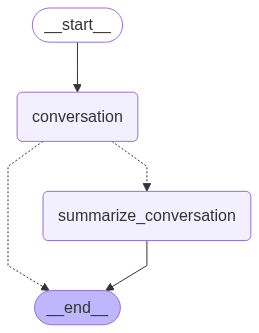

In [19]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from IPython.display import Image, display

workflow = StateGraph(MessagesState)
workflow.add_node('conversation', call_model)
workflow.add_node(summarize_conversation)

workflow.add_edge(START, 'conversation')
workflow.add_conditional_edges('conversation',
  should_continue,
  path_map={'summarize_conversation': 'summarize_conversation', '__end__': '__end__'})
workflow.add_edge('summarize_conversation', END)

memory = MemorySaver()

graph = workflow.compile(checkpointer = memory)
graph

In [20]:
config = {'configurable': {'thread_id':1}}
input_message = HumanMessage(content = 'Hi! I am Utkarsh')
output_messages = graph.invoke({'messages' : [input_message], 'summary':''}, config)

for m in output_messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi! I am Utkarsh
================================== Ai Message ==================================

Hi Utkarsh! It's nice to meet you. How can I help you today?


In [21]:
input_message = HumanMessage(content = 'What is my name?')
output_messages = graph.invoke({'messages' : [input_message], 'summary':''}, config)

for m in output_messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi! I am Utkarsh
================================== Ai Message ==================================

Hi Utkarsh! It's nice to meet you. How can I help you today?
================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Utkarsh. You just told me! 😊


In [22]:
input_message = HumanMessage(content = 'I like the 49ers')
output_messages = graph.invoke({'messages' : [input_message], 'summary':''}, config)

for m in output_messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi! I am Utkarsh
================================== Ai Message ==================================

Hi Utkarsh! It's nice to meet you. How can I help you today?
================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Utkarsh. You just told me! 😊
================================ Human Message =================================

I like the 49ers
================================== Ai Message ==================================

That's great! The 49ers are a very popular team. What do you like about them? Are you excited about the upcoming season?


In [23]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Hi! I am Utkarsh', additional_kwargs={}, response_metadata={}, id='a7131e66-2ad0-4227-b050-f162fe280511'), AIMessage(content="Hi Utkarsh! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--2e1a2fbb-6971-447d-a01a-4e43cb6b52ce-0', usage_metadata={'input_tokens': 7, 'output_tokens': 21, 'total_tokens': 28, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='What is my name?', additional_kwargs={}, response_metadata={}, id='d756a39b-d623-4130-a66c-5334a96bb558'), AIMessage(content='Your name is Utkarsh. You just told me! 😊', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--fecfe18f-961e

In [24]:
input_message = HumanMessage(content = 'I like Nick Bosa, isnt he the highest paid defense player?')
output_messages = graph.invoke({'messages' : [input_message], 'summary':''}, config)

for m in output_messages['messages']:
    m.pretty_print()

================================== Ai Message ==================================

That's great! The 49ers are a very popular team. What do you like about them? Are you excited about the upcoming season?
================================ Human Message =================================

I like Nick Bosa, isnt he the highest paid defense player?
================================== Ai Message ==================================

You're right, Nick Bosa is a fantastic player! And yes, he is currently the highest-paid defensive player in the NFL. He signed a massive contract extension with the 49ers in 2023. He definitely earned it with his performance!


In [25]:
graph.get_state(config)

StateSnapshot(values={'messages': [AIMessage(content="That's great! The 49ers are a very popular team. What do you like about them? Are you excited about the upcoming season?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--6aedc892-62af-45c7-84e6-116b9ef66ff5-0', usage_metadata={'input_tokens': 52, 'output_tokens': 32, 'total_tokens': 84, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='I like Nick Bosa, isnt he the highest paid defense player?', additional_kwargs={}, response_metadata={}, id='caff7ffb-09bc-4ed7-81c0-5302f687739d'), AIMessage(content="You're right, Nick Bosa is a fantastic player! And yes, he is currently the highest-paid defensive player in the NFL. He signed a massive contract extension with the 49ers in 2023. He definitely earned it with his performance!", additional_kwargs={}, response_metadata={'prompt